In [32]:
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow
import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.applications   import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, concatenate, Dense, Flatten,
                                     Activation, Conv2D, Dropout, AveragePooling2D, 
                                     GlobalAveragePooling2D, BatchNormalization)


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
def Evaluate(model: keras.engine.sequential.Sequential):
    print("Evalutions... ", "\n", 
      "Train: ", "loss -> ", model.evaluate(X_train, y_train)[0],
         "accuracy -> ", model.evaluate(X_train, y_train)[1], "\n",
      "Test: ", "loss -> ", model.evaluate(X_test, y_test)[0],
         "accuracy -> ", model.evaluate(X_test, y_test)[1], "\n",
      "Validation:", "loss -> ", model.evaluate(X_val, y_val)[0],
         "accuracy -> ", model.evaluate(X_val, y_val)[1])

def SizeOfNet(model: bytes):
    print("Size -->", len(model), "bytes")
    return len(model)

In [4]:
dataset=pd.read_csv('sample_labels.csv')
dataset

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


In [5]:
# number of findings

dataset['Finding Labels'].value_counts()

No Finding                                                3044
Infiltration                                               503
Effusion                                                   203
Atelectasis                                                192
Nodule                                                     144
                                                          ... 
Atelectasis|Edema|Effusion|Infiltration|Pneumonia            1
Atelectasis|Consolidation|Edema|Infiltration|Pneumonia       1
Atelectasis|Effusion|Hernia                                  1
Atelectasis|Hernia|Pneumothorax                              1
Cardiomegaly|Effusion|Emphysema                              1
Name: Finding Labels, Length: 244, dtype: int64

In [6]:
# define categories and separate them ->

diagnosis=np.array(dataset['Finding Labels'])
deseases=[]

for i in range(len(diagnosis)):
    splitter=diagnosis[i].split("|")
    if len(splitter)==1:
            deseases.append(splitter)
    else:
        lab=[]
        for j in range(len(splitter)):
            lab.append(splitter[j])
        deseases.append(lab)
            
len(deseases)

5606

In [7]:
# process x-rays

img_size=256
source=r'C:\Users\nikita\X-RAY\sample\images\\'
labels=[]
scans=[]

for i in tqdm(range(len(dataset["Image Index"]))):
    img=cv2.imread(source+dataset["Image Index"][i])
    if len(img.shape)>2: # to save images as (heigth , width, 3) rather than (hieght , width ,4)
        resize_img=cv2.resize(img,(img_size,img_size)) 
        scans.append(resize_img[:,:,:4])
    else :
        img=np.dstack([img] * 3)
        resize_img=cv2.resize(img,(img_size,img_size)) 
        scans.append(resize_img)

100%|██████████████████████████████████████████████████████████████████████████████| 5606/5606 [01:27<00:00, 64.20it/s]


In [8]:
def img_show(data,deseases,number_of_image):
    order=np.random.randint(0,len(data),number_of_image)
    plt.figure(figsize=(40,20))
    j = number_of_image/5
    for _,i in enumerate(order):
        plt.subplot(j,5,_+1)
        plt.imshow(data[i] , cmap="gray")
        label=""
        if i < len(deseases):
            for x in deseases[i]:
                label+=x+" , "

            
        plt.title(label+"\n"+f"size {data[i].shape}")
        #to remove the number that appear around image
        plt.xticks([]),plt.yticks([])
    plt.show()

C:\Users\nikita\AppData\Local\Temp/ipykernel_13468/981059814.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(j,5,_+1)


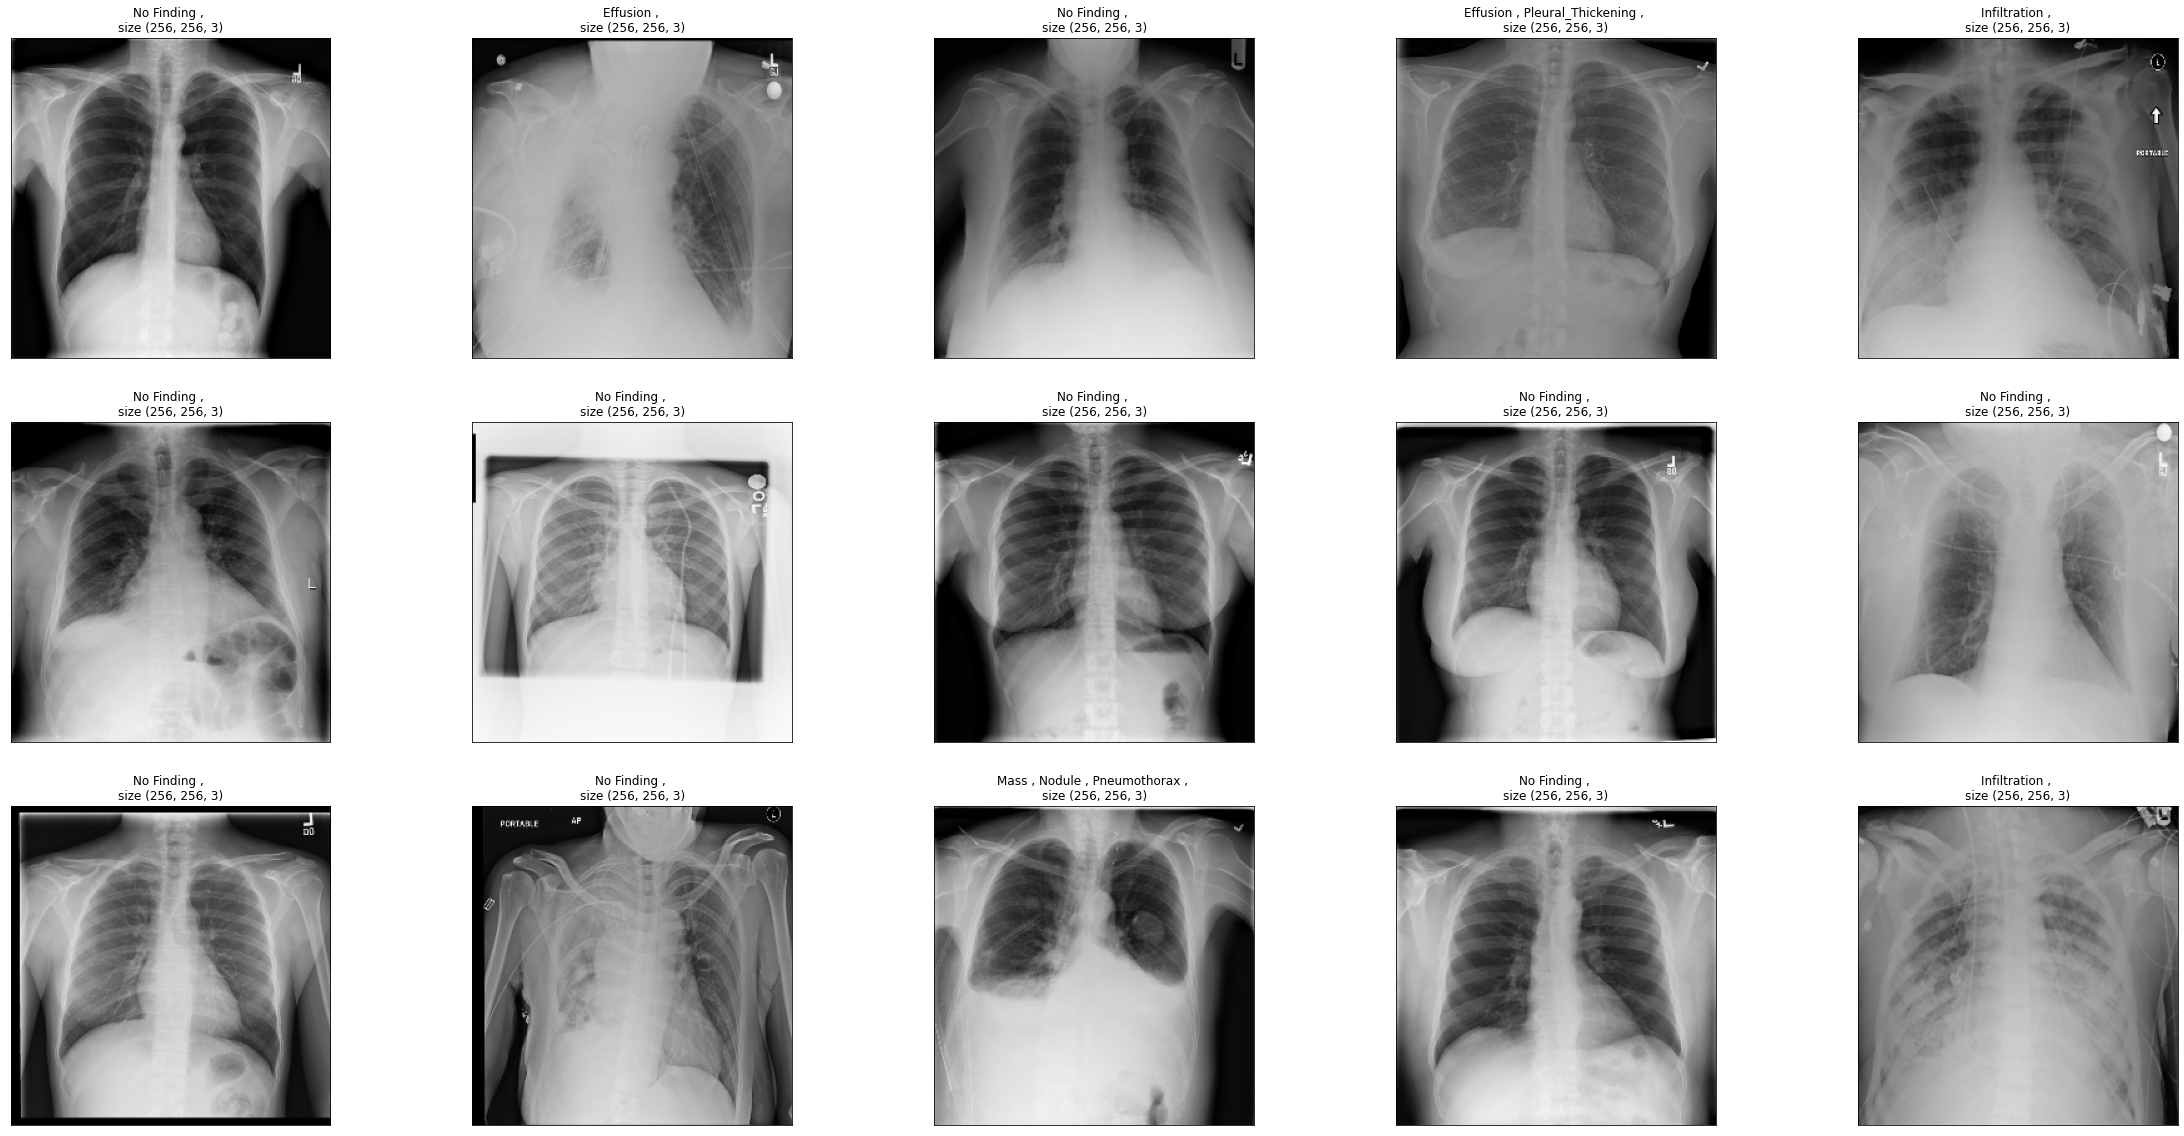

In [9]:
img_show(scans, deseases, 15)

In [10]:
# dictionary

classes={
0:"Hernia",
1:"Pneumonia",
2:"Fibrosis",
3:"Edema",
4:"Emphysema",
5:"Cardiomegaly",
6:"Pleural_Thickening",
7:"Consolidation",
8:"Pneumothorax",
9:"Mass",
10:"Nodule",
11:"Atelectasis",
12:"Effusion",
13:"Infiltration",
14:"No Finding",
}

def getter_class(code):
    return classes[code]

def getter_code(labels):
    for key,value  in classes.items():
        if value ==labels:
            return key

In [11]:
scans = np.array(scans)

for i in tqdm(range(len(deseases))):
    deseases[i]=[getter_code(x) for x in deseases[i]]
        

deseases

100%|██████████████████████████████████████████████████████████████████████████| 5606/5606 [00:00<00:00, 700153.89it/s]


[[4, 13, 6, 8],
 [5, 4],
 [14],
 [11],
 [5, 3, 12],
 [7, 9],
 [14],
 [14],
 [12],
 [14],
 [7, 12, 13, 10],
 [9],
 [14],
 [14],
 [12],
 [12],
 [12],
 [14],
 [9, 8],
 [5, 7],
 [7],
 [5, 7],
 [5, 7],
 [8],
 [14],
 [12],
 [7, 6],
 [13, 10],
 [14],
 [11],
 [11],
 [2],
 [13],
 [13],
 [14],
 [14],
 [14],
 [14],
 [2],
 [14],
 [7],
 [4],
 [14],
 [14],
 [13],
 [7, 9],
 [14],
 [11, 13, 9, 6],
 [13],
 [14],
 [14],
 [13],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [13, 10],
 [14],
 [4],
 [14],
 [13],
 [14],
 [14],
 [8],
 [4, 9],
 [14],
 [14],
 [14],
 [14],
 [14],
 [5, 4],
 [14],
 [14],
 [14],
 [14],
 [14],
 [13],
 [8],
 [4, 8],
 [4, 13],
 [14],
 [14],
 [14],
 [14],
 [13],
 [7, 12, 13],
 [7, 2],
 [14],
 [2, 6],
 [14],
 [14],
 [14],
 [12, 13],
 [2],
 [14],
 [14],
 [14],
 [10],
 [10],
 [9, 6],
 [13, 6],
 [12, 13],
 [14],
 [14],
 [14],
 [9],
 [14],
 [14],
 [14],
 [14],
 [14],
 [9],
 [12],
 [14],
 [14],
 [11],
 [14],
 [6],
 [14],
 [14],
 [14],
 [4],
 [14],
 [14],
 [14],
 [2],
 [14],
 [12],
 [14],

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
mlp=MultiLabelBinarizer()
Labels=mlp.fit_transform(deseases)
Labels = np.array(Labels)
type(Labels.shape), scans.shape

(tuple, (5606, 256, 256, 3))

In [13]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import accuracy_score
#split to train and test
X_train, y_train, X_test, y_test = iterative_train_test_split(scans, Labels, test_size = 0.3)
#split to valid and test
X_val, y_val, X_test, y_test = iterative_train_test_split(X_test, y_test, test_size = 0.5)

print("X_TRAIN shape ",X_train.shape, "\n", 
      "y_TRAIN shape ",y_train.shape, "\n",
      "X_VALIDATION shape ",X_val.shape, "\n", 
      "y_VALIDATION shape ",y_val.shape, "\n",
      "X_TEST shape ",X_test.shape, "\n", 
      "y_TEST shape ",y_test.shape, "\n",sep='')

X_TRAIN shape (3928, 256, 256, 3)
y_TRAIN shape (3928, 15)
X_VALIDATION shape (831, 256, 256, 3)
y_VALIDATION shape (831, 15)
X_TEST shape (847, 256, 256, 3)
y_TEST shape (847, 15)



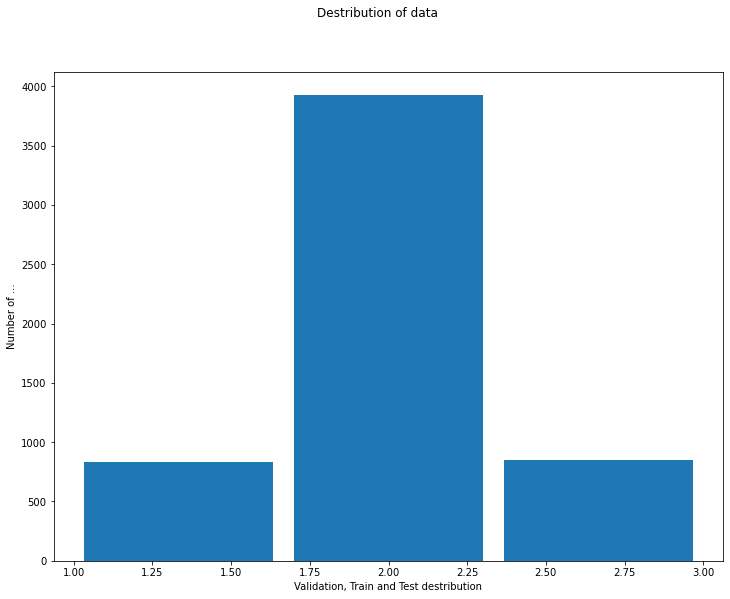

In [14]:
import seaborn as sns
def show_destribution():
    x_axes = np.arange(3)
    y_axes = []
    for train_el in X_train:
        y_axes.append(2)
    for val_el in X_val:
        y_axes.append(1)
    for test_el in X_test:
        y_axes.append(3)
    
    fig = plt.figure(figsize=(12, 9))
    plt.hist(x=y_axes, bins=3, zorder=2, rwidth=0.9)
    plt.xlabel('Validation, Train and Test destribution')
    plt.ylabel('Number of ...')
    plt.suptitle('Destribution of data')
    
show_destribution()

In [15]:
Inputs=Input((img_size,img_size,3))

#1
c1=Conv2D(64 , (3,3) , activation="relu" , padding="same")(Inputs)
c1=Conv2D(64 , (3,3) , activation="relu" , padding="same")(c1)
c1=Conv2D(64 , (3,3) , activation="relu" , padding="same")(c1)
p1=AveragePooling2D(pool_size=(3,3))(c1)
#2
c2=Conv2D(128 , (3,3) , activation="relu" , padding="same")(p1)
c2=Conv2D(128 , (3,3) , activation="relu" , padding="same")(c2)
c2=Conv2D(128 , (3,3) , activation="relu" , padding="same")(c2)
p2=AveragePooling2D(pool_size=(3,3))(c2)

#3

c3=Conv2D(256 , (5,5) , activation="relu" , padding="same")(p2)
c3=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c3)
c3=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c3)
p3=AveragePooling2D(pool_size=(2,2))(c3)

#4

c4=Conv2D(256 , (5,5) , activation="relu" , padding="same")(p3)
c4=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c4)
c4=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c4)
p4=AveragePooling2D(pool_size=(2,2))(c4)

#5

c5=Conv2D(256 , (5,5) , activation="relu" , padding="same")(p4)
c5=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c5)
c5=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c5)
p5=AveragePooling2D(pool_size=(2,2))(c5)

#6

c6=Conv2D(256 , (5,5) , activation="relu" , padding="same")(p5)
c6=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c6)
c6=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c6)
p6=AveragePooling2D(pool_size=(2,2))(c6)

#fully connected layers
f=Flatten()(p3)
#FC1
fc1=Dense(1024)(f)
b1=BatchNormalization()(fc1)
ac=Activation("relu")(b1)
d1=Dropout(0.2)(ac)

#FC2
fc2=Dense(1024)(d1)
b2=BatchNormalization()(fc2)
ac=Activation("relu")(b2)
d2=Dropout(0.2)(ac)

#FC3
fc3=Dense(1024)(d2)
b2=BatchNormalization()(fc3)
ac=Activation("relu")(b2)
d3=Dropout(0.2)(ac)


#FC4
x=Dense(512 , activation="relu")(d3)
x=Dense(512 , activation="relu")(x)
x=Dense(512 , activation="relu")(x)
x=Dense(256 , activation="relu")(x)
x=Dense(128 , activation="relu")(x)


output=Dense(len(classes) , activation="sigmoid")(x)

model=Model(inputs=Inputs , outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 average_pooling2d (AverageP  (None, 85, 85, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 85, 85, 128)       73856     
                                                             

In [16]:
checkpoint_path = "NIH_model_1_avg.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=1, min_delta = 0.001,
                                      min_lr=0.000001,
                                      mode = 'min',verbose=1)
    
]

In [17]:
#compilation
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.binary_crossentropy,metrics=["accuracy"] )

In [46]:
#fit
history=model.fit(X_train,y_train,epochs=10, 
          batch_size=32,validation_data=(X_val, y_val),verbose=1,callbacks=callbacks)

Epoch 1/10
123/123 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.4734
Epoch 1: val_loss improved from inf to 0.37327, saving model to NIH_model_1_avg.h5
123/123 [==============================] - 39s 306ms/step - loss: 0.2600 - accuracy: 0.4734 - val_loss: 0.3733 - val_accuracy: 0.5434 - lr: 1.0000e-04
Epoch 2/10
123/123 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.5332
Epoch 2: val_loss improved from 0.37327 to 0.27210, saving model to NIH_model_1_avg.h5
123/123 [==============================] - 37s 302ms/step - loss: 0.2077 - accuracy: 0.5332 - val_loss: 0.2721 - val_accuracy: 0.5434 - lr: 1.0000e-04
Epoch 3/10
123/123 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.5304
Epoch 3: val_loss improved from 0.27210 to 0.21830, saving model to NIH_model_1_avg.h5
123/123 [==============================] - 37s 303ms/step - loss: 0.2063 - accuracy: 0.5304 - val_loss: 0.2183 - val_accuracy: 0.5446 - lr: 1.0000e-04
Ep

In [48]:
model.load_weights(checkpoint_path)

In [19]:
Evaluate(model)

26/26 [==============================] - 2s 89ms/step - loss: 0.2061 - accuracy: 0.5223
Evalutions...  
 Train:  loss ->  0.19532157480716705 accuracy ->  0.5249490737915039 
 Test:  loss ->  0.20642375946044922 accuracy ->  0.5100353956222534 
 Validation: loss ->  0.20614267885684967 accuracy ->  0.5222623348236084


In [20]:
model.save('./saved_models_avg')

INFO:tensorflow:Assets written to: ./saved_models_avg\assets


**POST-TRAINING QUANTIZATION**


In [46]:
def representative_dataset():
    for data in tf.data.Dataset.from_tensor_slices((X_train)).batch(1).take(100):
        yield [tf.dtypes.cast(data, tf.float32)]

In [49]:
interpreter = tf.lite.Interpreter(model_path='my_tflite_model.tflite')

In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model('./saved_models')
# converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
converter.allow_custom_ops = True
my_tflite_model = converter.convert()

In [24]:
before_quant = SizeOfNet(my_tflite_model)

Size --> 236965844 bytes


In [25]:
converter_lite = tf.lite.TFLiteConverter.from_saved_model('./saved_models')
# converter_lite = tf.lite.TFLiteConverter.from_keras_model(model)
converter_lite.optimizations = [tf.lite.Optimize.DEFAULT]
converter_lite.allow_custom_ops = True

print("Input 1 for only integer, 2 for float16, 3 for dynamic")
quant_choice = int(input())
if (quant_choice == 1):
    converter_lite.experimental_new_converter =True
    converter_lite.representative_dataset = representative_dataset
    converter_lite.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter_lite.inference_input_type = tf.int8  # or tf.uint8
    converter_lite.inference_output_type = tf.int8  # or tf.uint8
    my_tflite_quant_model = converter_lite.convert()
elif (quant_choice == 2):
    converter_lite.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_lite.target_spec.supported_types = [tf.float16]
    my_tflite_quant_model = converter_lite.convert()
elif (quant_choice == 3):
    converter_lite.optimizations = [tf.lite.Optimize.DEFAULT]
    my_tflite_quant_model = converter_lite.convert()
else:
    print("!Wrong input")

Input 1 for only integer, 2 for float16, 3 for dynamic
2


In [26]:
after_quant = SizeOfNet(my_tflite_quant_model)

Size --> 118492160 bytes


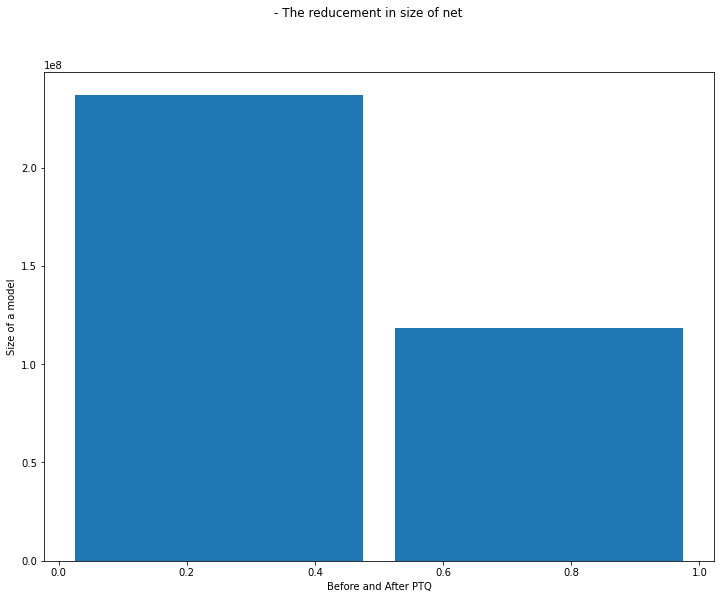

In [27]:
def reducemetn_of_size(before, after):
    plt.figure(figsize=(12,9))
    x_before = np.zeros(shape=(1, before))
    x_after = np.ones(shape=(1, after))
    
    x_axes = np.append(x_before, x_after)
    plt.hist(x=x_axes, bins=2, zorder=2, rwidth=0.9)
    plt.xlabel('Before and After PTQ')
    plt.ylabel('Size of a model')
    plt.suptitle("- The reducement in size of net")
    
reducemetn_of_size(before_quant, after_quant)

In [30]:
with open("my_tflite_model.tflite", "wb") as f:
    f.write(my_tflite_model)

In [31]:
with open("my_tflite_quant_model.tflite", "wb") as f:
    f.write(my_tflite_quant_model)

In [40]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 256, 256,   3]),
  'shape_signature': array([ -1, 256, 256,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [50]:
interpreter.allocate_tensors()

RuntimeError: Encountered unresolved custom op: Mul.
See instructions: https://www.tensorflow.org/lite/guide/ops_customNode number 13 (Mul) failed to prepare.Encountered unresolved custom op: Mul.
See instructions: https://www.tensorflow.org/lite/guide/ops_customNode number 13 (Mul) failed to prepare.

In [44]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="my_tflite_quant_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

RuntimeError: Encountered unresolved custom op: Mul.
See instructions: https://www.tensorflow.org/lite/guide/ops_customNode number 33 (Mul) failed to prepare.Encountered unresolved custom op: Mul.
See instructions: https://www.tensorflow.org/lite/guide/ops_customNode number 33 (Mul) failed to prepare.

**PRUNING**


In [35]:
import tensorflow_model_optimization as tfmot

print('Choose percentage of pruning...')
pruning_choice = int(input()) / 100

batch_size = 32
epochs = 10
end_step = np.ceil(len(X_train) / batch_size).astype(np.int32) * epochs
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                       final_sparsity=pruning_choice,
                                                       begin_step=0,
                                                       end_step=end_step)

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)

Choose percentage of pruning...
65


C:\Users\nikita\AppData\Roaming\Python\Python39\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  mask = self.add_variable(
C:\Users\nikita\AppData\Roaming\Python\Python39\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  threshold = self.add_variable(
C:\Users\nikita\AppData\Roaming\Python\Python39\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.pruning_step = self.add_variable(


In [36]:
model_for_pruning.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.binary_crossentropy,metrics=["accuracy"] )

model_for_pruning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 prune_low_magnitude_conv2d   (None, 256, 256, 64)     3522      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 256, 256, 64)     73794     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 256, 256, 64)     73794     
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 85, 85, 64)       1         
 ling2d (PruneLowMagnitude)                                  

In [37]:
import tempfile

logdir = tempfile.mkdtemp()

prune_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=1),
    tf.keras.callbacks.ModelCheckpoint("NIH_model_1.h5",save_best_only=True,verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=1, min_delta = 0.001,
                                      min_lr=0.000001,
                                      mode = 'min',verbose=1),
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X_train, y_train,
                  batch_size=batch_size, epochs=epochs,validation_data=(X_val, y_val),verbose=1,
                  callbacks=prune_callbacks)

Epoch 1/10
  6/123 [>.............................] - ETA: 32s - loss: 0.2028 - accuracy: 0.4740WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1167s vs `on_train_batch_end` time: 0.1668s). Check your callbacks.


123/123 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.5307
Epoch 1: val_loss improved from inf to 0.24088, saving model to NIH_model_1.h5
123/123 [==============================] - 54s 344ms/step - loss: 0.2045 - accuracy: 0.5307 - val_loss: 0.2409 - val_accuracy: 0.5434 - lr: 1.0000e-04
Epoch 2/10
123/123 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.5315
Epoch 2: val_loss improved from 0.24088 to 0.23514, saving model to NIH_model_1.h5
123/123 [==============================] - 41s 333ms/step - loss: 0.2022 - accuracy: 0.5315 - val_loss: 0.2351 - val_accuracy: 0.5434 - lr: 1.0000e-04
Epoch 3/10
123/123 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.5310
Epoch 3: val_loss improved from 0.23514 to 0.21270, saving model to NIH_model_1.h5
123/123 [==============================] - 42s 337ms/step - loss: 0.2013 - accuracy: 0.5310 - val_loss: 0.2127 - val_accuracy: 0.5089 - lr: 1.0000e-04
Epoch 4/10
123/123 [=====

In [38]:
model_for_pruning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 prune_low_magnitude_conv2d   (None, 256, 256, 64)     3522      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 256, 256, 64)     73794     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 256, 256, 64)     73794     
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 85, 85, 64)       1         
 ling2d (PruneLowMagnitude)                                  

In [39]:
Evaluate(model_for_pruning)

27/27 [==============================] - 3s 94ms/step - loss: 0.2302 - accuracy: 0.5398
Evalutions...  
 Train ->  [0.22493848204612732, 0.5401273965835571] 
 Test ->  [0.22988876700401306, 0.5321428775787354] 
 Validation ->  [0.23018023371696472, 0.5398335456848145]
